In [179]:
# importing packages
import os
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sci
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sktime.classification.kernel_based import RocketClassifier


# defining reading function

def getCSMat(recordFile, outputFile, preCS = 100, postCS = 150):  
    # reshapping some data
    lfp = (np.array(recordFile['LFP'])).flatten()
    CS_offset = (np.array(outputFile['CS_offset'])).flatten()
    CS_onset = (np.array(outputFile['CS_onset'])).flatten()
    sortingResul = (np.array(outputFile['sorting_result']))
    
    # setting necessary values
    dur = CS_offset - CS_onset # duration for all CSs
    validDur = np.max(dur) # max duration considered to build a matrix
    byCSData = np.zeros((dur.shape[0], (validDur + (preCS + postCS))))
    
    # make the basic CS matrix
    for cs in range(len(dur)):
        onset = CS_onset[cs]
        pre = onset - preCS
        post = onset + (validDur + postCS)
        currTrial = lfp[pre:post]
        byCSData[cs, :currTrial.shape[0]] = currTrial  
    
    standard = np.zeros((byCSData.shape[0], byCSData.shape[1]))
    ms = 0
    for row in range(byCSData.shape[0]):
        mean = np.mean(byCSData, axis = 0)
        sd = np.std(byCSData, axis = 0)
        currMS = byCSData[row, ms]
        newMS = (currMS - mean[ms])/sd[ms]
        standard[row, ms] = newMS
        ms = ms + 1

    return byCSData, standard, sortingResul

def getCSMat2(recordFile, outputFile, preCS = 100, postCS = 150, dur = 300):  
    # reshapping some data
    lfp = (np.array(recordFile['LFP'])).flatten()
    CS_offset = (np.array(outputFile['CS_offset'])).flatten()
    CS_onset = (np.array(outputFile['CS_onset'])).flatten()
    sortingResul = (np.array(outputFile['sorting_result']))
    
    # setting necessary values
    validDur = np.max(dur) # max duration considered to build a matrix
    byCSData = np.zeros((dur, (validDur + (preCS + postCS))))
    
    # make the basic CS matrix
    for cs in range(dur):
        onset = CS_onset[cs]
        pre = onset - preCS
        post = onset + (validDur + postCS)
        currTrial = lfp[pre:post]
        byCSData[cs, :currTrial.shape[0]] = currTrial  
    
    standard = np.zeros((byCSData.shape[0], byCSData.shape[1]))
    ms = 0
    for row in range(byCSData.shape[0]):
        mean = np.mean(byCSData, axis = 0)
        sd = np.std(byCSData, axis = 0)
        currMS = byCSData[row, ms]
        newMS = (currMS - mean[ms])/sd[ms]
        standard[row, ms] = newMS
        ms = ms + 1

    return byCSData, standard, sortingResul

def rawNames(fileNames):
    basename = os.path.basename(fileNames)
    filename_without_ext = os.path.splitext(basename)[0]
    return filename_without_ext

def get_dicts(rawDict, stdDict, labelDict, csAmountArray):
    raw, Zscore, labels = getCSMat(signalInfo, sortInfo)
    stdDict[currSession] = Zscore 
    rawDict[currSession] = raw
    labelDict[currSession] = labels
    csAmountArray[data] = Zscore.shape[0]

In [110]:
# setting paths for data
data_names = "/Users/Juliana/Documents/GitHub/csNet/raw_data/lfp/"
sorted_folder = "/Users/Juliana/Documents/GitHub/csNet/raw_data/sorted/"

# getting name of files
dado = glob.glob(data_names + '*.mat')
classif = glob.glob(sorted_folder + '*.mat')
dado = np.sort(dado) # put two arrays into the same order to match files
classif = np.sort(classif)

namesArray = np.empty(shape = (len(dado)), dtype = "U25")
for session in range(len(dado)):
    nome = np.array(rawNames(dado[session]))
    namesArray[session] = nome

# read in sorted data and electric data, build matrices
csStd = {}
csRaw = {}
csLabels = {}
csAmount = np.zeros(shape = (len(dado)))

for data in range(len(dado)):
    signalInfo = sci.loadmat(dado[data])
    sortInfo = sci.loadmat(classif[data])
    currSession = namesArray[data]
    raw, Zscore, labels = getCSMat(signalInfo, sortInfo)
    csStd[currSession] = Zscore 
    csRaw[currSession] = raw
    csLabels[currSession] = labels
    csAmount[data] = Zscore.shape[0]

In [111]:
# getting inputs: -50, 0, 50, and 100 ms after onset values for each CS in each session
csAmount = csAmount.astype(int)

input1 = np.zeros(shape = (np.sum(csAmount)))
input2 = np.zeros(shape = (np.sum(csAmount)))
input3 = np.zeros(shape = (np.sum(csAmount)))
input4 = np.zeros(shape = (np.sum(csAmount)))
mss = np.array([50, 100, 150, 200], dtype = "int")

# building the input arrays for the model
row = 0
for dict in range(len(namesArray)): 
    currDictName = namesArray[dict]
    currDict = csStd[currDictName]

    firstInput = currDict[:, mss[0]]
    secondInput = currDict[:, mss[1]]
    thirdInput = currDict[:, mss[2]]
    fourthInput = currDict[:, mss[3]]

    endPoint = row + currDict.shape[0]
    input1[row:endPoint] = firstInput
    input2[row:endPoint] = secondInput
    input3[row:endPoint] = thirdInput
    input4[row:endPoint] = fourthInput
    
    row = row + currDict.shape[0]   
# building a big label array
labels = np.zeros(shape = (np.sum(csAmount)))
idx = 0
for data in range(len(namesArray)):
    nomeLabelSet = namesArray[data]
    currLabelSet = csLabels[nomeLabelSet]
    flattened = currLabelSet.flatten()
    
    endPoint = idx + flattened.shape[0]
    labels[idx:endPoint] = flattened

    idx = idx + flattened.shape[0]

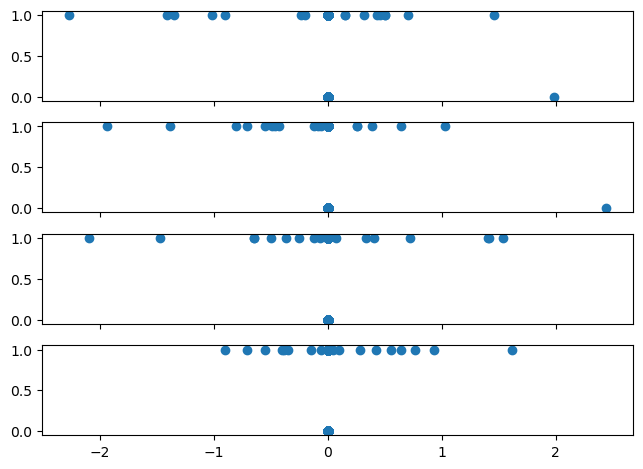

In [112]:
# plotting the relationship between sorting label and input types
labelFig, (sort1, sort2, sort3, sort4) = plt.subplots(nrows = 4, ncols = 1, sharex = True)

sort1.plot(input1, labels, "o")
sort2.plot(input2, labels, "o")
sort3.plot(input3, labels, "o")
sort4.plot(input4, labels, "o")
plt.tight_layout()

In [119]:
print(input1.shape, input2.shape, input3.shape, input4.shape, labels.shape)

(5681,) (5681,) (5681,) (5681,) (5681,)


In [123]:
# building logistic regression

# naming x and y values
xValues = np.array([input1, input2, input3, input4])
yValues = labels

# separating dataset into train and test sets
xTrain, xTest, yTrain, yTest = train_test_split(xValues.T, yValues, test_size = 0.3)

# # instantiate the model (using the default parameters)
log = LogisticRegression()
# fit the model with data
log.fit(xTrain, yTrain)
yPred = log.predict(xTest)

## Plotting results of this model

Text(0.5, 23.52222222222222, 'Predicted label')

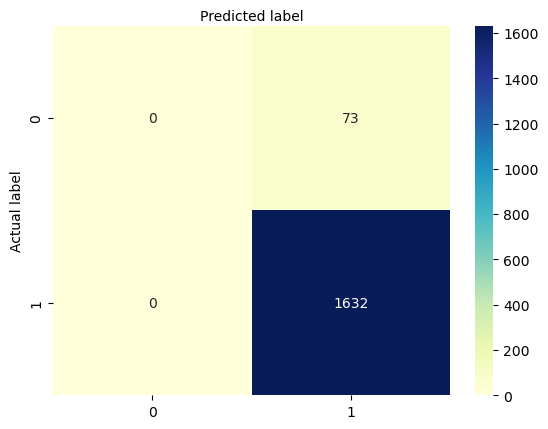

In [151]:
# confusion matrix 
cf = confusion_matrix(yTest, yPred)
class_names = [0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set_ylabel("Actual label")
ax.set_xlabel("Predicted label")

In [154]:
cf

array([[   0,   73],
       [   0, 1632]])

In [163]:
tp = cf[1, 1]
tn = cf[0, 0]
fp = cf[0, 1]
fn = cf[1, 0]

# accuracy of the classifier 
acc = (tp + tn)/(tp + tn + fp + fn)
# proportion in the data
tprop = np.sum(labels)/labels.shape[0]
diff = acc = tprop

In [167]:
## calculated specificity to examine how well is the model to predict as invalid a cs that is actually invalid
specif = tn/(tn + fp)
# I used specificity and not sensitivity because there are way more valid cases than invalid. And I want it to remove the invalid cases. 
# the sensitivity of the model would be higher anyway.
sens = tp /(tp + fn)
print(specif, sens)

0.0 1.0


In [169]:
# Now, I tried using a classification algorithm specific to time series classification.
# It is miniRocketk, from sktime. Sktime is a library with models that are specific machine learning problems with time series.

# trying sktime
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import load_unit_test
X_train, y_train = load_unit_test(split="train", return_X_y=True)
X_test, y_test = load_unit_test(split="test", return_X_y=True) 
clf = RocketClassifier(num_kernels=500) 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test) 

/Users/Juliana/miniconda3/envs/csNet/lib/python3.9/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/Users/Juliana/miniconda3/envs/csNet/lib/python3.9/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_convert_series_cell_to_numpy)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/Juliana/miniconda3/envs/csNet/lib/python3.9/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/Users/Juliana/miniconda3/envs/csNet/lib/python3.9/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_con

In [188]:
X_train

,dim_0
0,0 573.0 1 375.0 2 301.0 3 ...
1,0 394.0 1 264.0 2 140.0 3 ...
2,0 603.0 1 348.0 2 176.0 3 ...
3,0 428.0 1 309.0 2 199.0 3 ...
4,0 372.0 1 310.0 2 203.0 3 ...
5,0 448.0 1 344.0 2 183.0 3 ...
6,0 621.0 1 322.0 2 221.0 3 ...
7,0 597.0 1 409.0 2 142.0 3 ...
8,0 525.0 1 431.0 2 248.0 3 ...
9,0 587.0 1 382.0 2 165.0 3 ...


In [ ]:
# trying with mean of interval, instead of a specific time point

input5 = np.zeros(shape = (np.sum(csAmount)))
input6 = np.zeros(shape = (np.sum(csAmount)))
input7 = np.zeros(shape = (np.sum(csAmount)))
input8 = np.zeros(shape = (np.sum(csAmount)))
mss = np.array([0, 50, 100, 150, 200, 250], dtype = "int")

# building the input arrays for the model
row = 0
for dict in range(len(namesArray)): 
    currDictName = namesArray[dict]
    currDict = csStd[currDictName]

    fiveInput = currDict[:, mss[0]:mss[1]]
    sixInput = currDict[:, mss[100]:mss[150]]
    sevInput = currDict[:, mss[2]]
    eightInput = currDict[:, mss[3]]

    endPoint = row + currDict.shape[0]
    input5[row:endPoint] = firstInput
    input6[row:endPoint] = secondInput
    input7[row:endPoint] = thirdInput
    input8[row:endPoint] = fourthInput
    
    row = row + currDict.shape[0] 

In [ ]:
# making a square time series matrix

tsStd = {}
tsRaw = {}
tsLabels = {}
tsAmount = np.zeros(shape = (len(dado)))

for data in range(len(dado)):
    signalInfo = sci.loadmat(dado[data])
    sortInfo = sci.loadmat(classif[data])
    currSession = namesArray[data]
    raw, Zscore, labels = getCSMat(signalInfo, sortInfo)
    tsStd[currSession] = Zscore 
    tsRaw[currSession] = raw
    tsLabels[currSession] = labels
    tsAmount[data] = Zscore.shape[0]

In [221]:
def getCSMat2(recordFile, outputFile, preCS = 100, postCS = 150):  
    # reshapping some data
    lfp = (np.array(recordFile['LFP'])).flatten()
    CS_offset = (np.array(outputFile['CS_offset'])).flatten()
    CS_onset = (np.array(outputFile['CS_onset'])).flatten()
    sortingResul = (np.array(outputFile['sorting_result']))
    
    # setting necessary values
    dur = CS_offset - CS_onset # duration for all CSs
    validDur = np.max(dur) # max duration considered to build a matrix
    df = pd.DataFrame(index = np.array(range((np.sum(tsAmount).astype(int))))))
    df

    column_series = pd.Series(np.array([0, 1, 2, 3]))
    # To assign that column to an existing DataFrame:


    
    # make the basic CS matrix
    for cs in range(len(dur)):
        onset = CS_onset[cs]
        pre = onset - preCS
        post = onset + (validDur + postCS)
        currTrial = lfp[pre:post]
        column_series = pd.Series(currTrial)
         
    
    standard = np.zeros((byCSData.shape[0], byCSData.shape[1]))
    ms = 0
    for row in range(byCSData.shape[0]):
        mean = np.mean(byCSData, axis = 0)
        sd = np.std(byCSData, axis = 0)
        currMS = byCSData[row, ms]
        newMS = (currMS - mean[ms])/sd[ms]
        standard[row, ms] = newMS
        ms = ms + 1

    return byCSData, standard, sortingResul

# setting paths for data
data_names = "/Users/Juliana/Documents/GitHub/csNet/raw_data/lfp/"
sorted_folder = "/Users/Juliana/Documents/GitHub/csNet/raw_data/sorted/"

# getting name of files
dado = glob.glob(data_names + '*.mat')
classif = glob.glob(sorted_folder + '*.mat')
dado = np.sort(dado) # put two arrays into the same order to match files
classif = np.sort(classif)

namesArray = np.empty(shape = (len(dado)), dtype = "U25")
for session in range(len(dado)):
    nome = np.array(rawNames(dado[session]))
    namesArray[session] = nome

# read in sorted data and electric data, build matrices
csStd = {}
csRaw = {}
csLabels = {}
csAmount = np.zeros(shape = (len(dado)))

for data in range(len(dado)):
    signalInfo = sci.loadmat(dado[data])
    sortInfo = sci.loadmat(classif[data])
    currSession = namesArray[data]
    raw, Zscore, labels = getCSMat(signalInfo, sortInfo)
    csStd[currSession] = Zscore 
    csRaw[currSession] = raw
    csLabels[currSession] = labels
    csAmount[data] = Zscore.shape[0]
      

ValueError: Data must be 1-dimensional, got ndarray of shape (351, 480) instead

In [ ]:
#sum = (np.sum(tsAmount)).astype(int)

In [218]:
df['dim_0'] = np.nan

0 351
(351, 480)
(0, 1)


ValueError: could not broadcast input array from shape (351,480) into shape (0,1)

In [209]:
sum

5681

In [204]:
np.sum(tsAmount)

5681.0

In [190]:
df

,dim_0
0,"[1732.0, 1904.0, 2032.0, 2096.0, 2208.0, 2248...."
1,"[2316.0, 2376.0, 2392.0, 2444.0, 2452.0, 2512...."
2,"[-1504.0, -1428.0, -1432.0, -1412.0, -1332.0, ..."
3,"[-4072.0, -4212.0, -4376.0, -4392.0, -4408.0, ..."
4,"[-6776.0, -6704.0, -6584.0, -6520.0, -6432.0, ..."
...,...
346,"[-5808.0, -5812.0, -5820.0, -5856.0, -5812.0, ..."
347,"[-12.0, -64.0, -72.0, -72.0, -168.0, -188.0, -..."
348,"[12.0, -64.0, -84.0, -180.0, -208.0, -228.0, -..."
349,"[-5936.0, -6036.0, -6040.0, -6104.0, -6152.0, ..."


In [ ]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import load_unit_test
X_train, y_train = load_unit_test(split="train", return_X_y=True)
X_test, y_test = load_unit_test(split="test", return_X_y=True) 
clf = RocketClassifier(num_kernels=500) 
clf.fit(X_train, y_train) 
RocketClassifier(...)
y_pred = clf.predict(X_test) 